# Map showing release locations for each LAPS site

Author: Johanna L K Wren

Email:  johanna.wren@noaa.gov

Date:   April 28, 2023


## Description
This map is for the LAPS sensitivity analysis manuscript. It shows the release locations on a bathymetry background for each release site. 


In [1]:
import pygmt
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr

## Read in locations
Read in a csv file with sample locations you want to plot on the map. I used a subset version of the [sheet you sent me](https://docs.google.com/spreadsheets/d/1U3xV9l82g1hIV5LvcOzaZvO4nP2HpUurCcJLoAsgoC8/edit?usp=sharing) where I only have unique locations, and I changed all locations to be in decimal degrees. 

In [2]:
# Read in CSV file
sites = pd.read_csv('/Users/jwren/Downloads/LAPS_release_sites_noHI_newKiritimati.csv')
pts = pd.read_csv('~/Documents/LAPS/LAPS_release_sites_short.csv')
pts = pts.rename(columns={'Name ': 'Name'})
pts = pts.drop(index=[7,8])
pts = pts.replace(' French Frigate Shoals', 'Lalo')
pts.reset_index(drop=True, inplace=True)

## Read in earth relief data

There are different resolutions for this that can be found [here](https://www.generic-mapping-tools.org/remote-datasets/earth-relief.html). I used the finest resolution for the figure, which is a 1 arc second resolution, but it takes a while to get the data and to plot it. If you want to play around with figures I'd use a lower resolution dataset for the testing, then switch to the high resoulution for the final figure. 

I downloaded the bathymetry for the full region, then made a hillshade grid to make the figure look more 3D. It helps with the illumination when plotting. Feel free to play around with the elevation and azimuth to see which light angle works best for your region of interest. 


In [17]:
grd = xr.load_dataset('/Users/jwren/Documents/LAPS/2013/HYCOM_LAPS_Sensitivity_6757.nc') #Downloads/HYCOM_LAPS_3801.nc')
grid2 = grd['WATER_U'].sel(TIME='2012-07-01').drop('TIME') #'2003-02-27').drop('TIME')
grid = grid2.sel(LEV1_15=0).drop('LEV1_15')
grid

<xarray.DataArray 'WATER_U' (LATITUDE1501_2251: 751, LONGITUDE3751_5251: 1501)>
array([[        nan,         nan, -0.034     , ...,  0.275     ,
         0.286     ,  0.29000002],
       [        nan,         nan, -0.021     , ...,  0.22700001,
         0.23200001,  0.23300001],
       [        nan,         nan, -0.021     , ...,  0.178     ,
         0.18300001,  0.187     ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * LONGITUDE3751_5251  (LONGITUDE3751_5251) float64 120.0 120.1 ... 239.9 240.0
  * LATITUDE1501_2251   (LATITUDE1501_2251) float64 0.0 0.08 0.16 ... 49.96 50.0
Attributes:
    long_name:  eastward water velocity [m/s]
    history:    From http://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soes...

In [18]:
speed = (grd['WATER_U']**2 + grd['WATER_V']**2)**(1/2)
speed = speed.sel(LEV1_15=0).drop('LEV1_15')
grid = speed.sel(TIME='2012-07-01').drop('TIME')

In [48]:
nodes = [(x,y) for x in grid.LONGITUDE3751_5251.values for y in grid.LATITUDE1501_2251.values]

nodes = pd.DataFrame(nodes, columns=['Longitude', 'Latitude'])
nodes

,Longitude,Latitude
0,120.0,0.000000
1,120.0,0.080000
2,120.0,0.160000
3,120.0,0.240000
4,120.0,0.320000
...,...,...
1127246,240.0,49.840000
1127247,240.0,49.880001
1127248,240.0,49.919998
1127249,240.0,49.959999


/Users/jwren/miniconda3/envs/pyGMT/lib/python3.10/site-packages/pygmt/clib/conversion.py:107: RuntimeWarning: Grid may have irregular spacing in the 'LONGITUDE3751_5251' dimension, but GMT only supports regular spacing. Calculated regular spacing 0.08 is assumed in the 'LONGITUDE3751_5251' dimension.
  warnings.warn(msg, category=RuntimeWarning)
/Users/jwren/miniconda3/envs/pyGMT/lib/python3.10/site-packages/pygmt/clib/conversion.py:107: RuntimeWarning: Grid may have irregular spacing in the 'LATITUDE1501_2251' dimension, but GMT only supports regular spacing. Calculated regular spacing 0.06666666666666667 is assumed in the 'LATITUDE1501_2251' dimension.
  warnings.warn(msg, category=RuntimeWarning)
/Users/jwren/miniconda3/envs/pyGMT/lib/python3.10/site-packages/pygmt/clib/conversion.py:107: RuntimeWarning: Grid may have irregular spacing in the 'LONGITUDE3751_5251' dimension, but GMT only supports regular spacing. Calculated regular spacing 0.08 is assumed in the 'LONGITUDE3751_5251' 

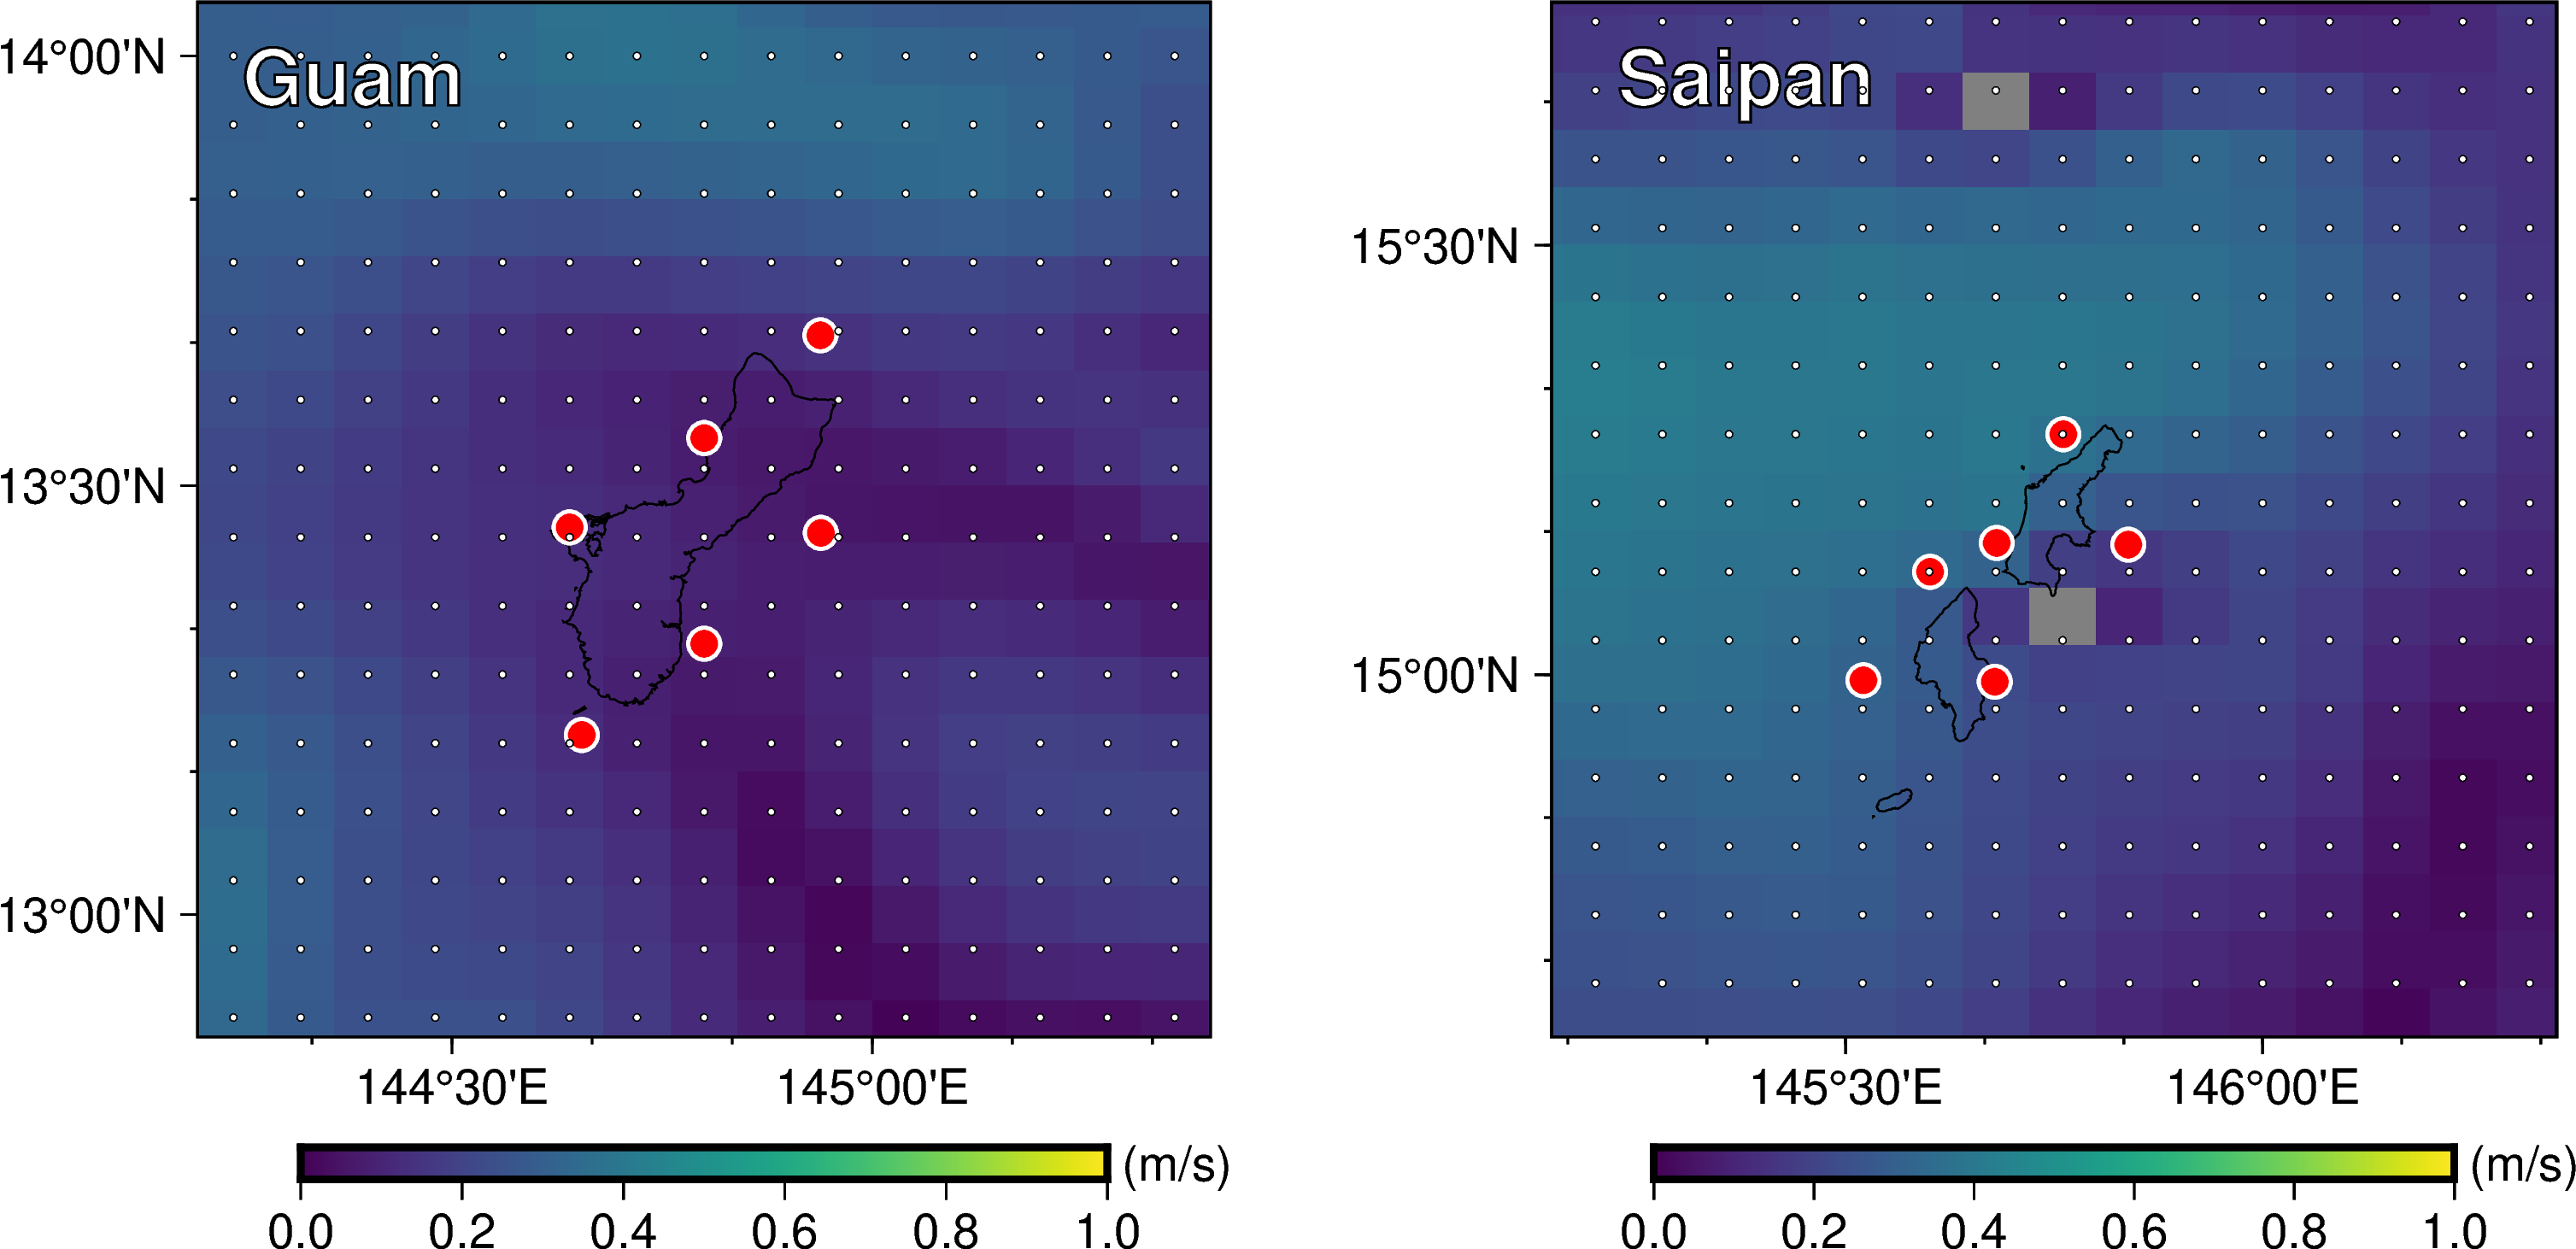

In [51]:
# Initialize the figure
fig = pygmt.Figure()

# Start looping trough the figures
with fig.subplot(nrows=3, ncols=4, figsize=('20i', '15i'), frame='a', margins=["0.4i", "0.6i"]):
    for i in range(2):        
        region=[pts.Lon[i]-0.6, pts.Lon[i]+0.6, pts.Lat[i]-0.6, pts.Lat[i]+0.6]
        # Make the figure
        with fig.set_panel(panel=i):
            with pygmt.config(MAP_FRAME_TYPE="plain"):
            # Make the basemap
                fig.basemap(region=region, projection="M")
            # Make the grid image using bathymetry data and shade it using the hillshade grid we made above
            # For ocean only
            pygmt.makecpt(cmap='viridis', series=[0,1])
            fig.grdimage(
                grid=grid)
            # Make colorbar
            fig.colorbar(frame=["a", "y+l(m/s)"])#, position="JMR+o0.5c/0c+w4i/0.5c") 

            # Add a coastline for a crisper look
            fig.coast(resolution='f', shorelines='0.5p,black')
            # Plot sampling stations
            fig.plot(x=sites.Lon, y=sites.Lat, style="c9p", color="red", pen='1p,white')
            # Add name
            fig.text(text=pts.Name[i], x=pts.Lon[i]-0.55, y=pts.Lat[i]+0.55, font="22p,Helvetica-Bold,white,-=0.6p,black", justify='TL')
            
            # Add points for grid
            #fig.plot(x=nodes.Longitude, y=nodes.Latitude, style='c2p', color='white', pen='black')

#fig.colorbar(position="JBC+o0.5c/0c+w4i/0.5c", frame=["y+l(m/s)", "x+l'Current speed'"])
# Display figure
fig.show()

#fig.savefig('testSites_HYCOM.png')

In [57]:
# Initialize the figure
fig = pygmt.Figure()

# Start looping trough the figures
with fig.subplot(nrows=3, ncols=4, figsize=('20i', '15i'), frame='a', margins=["0.4i", "0.6i"]):
    for i in range(10):
        region=[pts.Lon[i]-0.5, pts.Lon[i]+0.5, pts.Lat[i]-0.5, pts.Lat[i]+0.5]
        # Get the bathymetry data
        grid = pygmt.datasets.load_earth_relief(resolution="01s", region=region)
        # Get the hillshade grid
        dgrid = pygmt.grdgradient(grid=grid, azimuth=30)
        # Set all points on land to Nan
        gridOcean = pygmt.grdclip(grid, above=[0.01, 'Nan'])
        # Set all points in the ocean to Nan
        gridLand = pygmt.grdclip(grid, below=[0.01, 'Nan'])
        
        # Make the figure
        with fig.set_panel(panel=i):
            with pygmt.config(MAP_FRAME_TYPE="plain"):
            # Make the basemap
                fig.basemap(region=region, projection="M")
            # Make the grid image using bathymetry data and shade it using the hillshade grid we made above
            # For ocean only
            pygmt.makecpt(cmap='gmt/abyss', series=[-5500,0])
            fig.grdimage(
                grid=gridOcean,
                #cmap='gmt/abyss',
                shading=dgrid,
                transparency=0)
            # Make colorbar
            fig.colorbar(frame=["a2000f500", "y+l(m)"])#, position="JMR+o0.5c/0c+w4i/0.5c") 
            # Make gray color palette for land
            pygmt.makecpt(cmap='gray70', series=[0.01,1000])
            # For land only
            fig.grdimage(
                grid=gridLand,
                cmap=True,
                shading=dgrid,
                nan_transparent=True)

            # Add a coastline for a crisper look
            fig.coast(resolution='f', shorelines='0.5p,black')
            # Plot sampling stations
            fig.plot(x=sites.Lon, y=sites.Lat, style="c9p", color="red", pen='1p,white')
            # Add name
            fig.text(text=pts.Name[i], x=pts.Lon[i]-0.45, y=pts.Lat[i]+0.45, font="22p,Helvetica-Bold,white,-=0.6p,black", justify='TL')
            
            # Add points for grid
            fig.plot(x=nodes.Longitude, y=nodes.Latitude, style='c2p', color='white', pen='black')


#fig.colorbar(position="JBC+w10c/0.25c+h", frame="a2000f500+lDepth (m)")
# Display figure
#fig.show()

fig.savefig('LAPS_releaseSites_bathyGrid.png')

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
pygmt-session [WARNING]: Remote dataset given to a d